## Utilization Prediction

### Import Libraries

In [26]:
import pandas as pd
import numpy as np

import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

%matplotlib inline

### Import Data

In [2]:
charging_sessions_data = pd.read_csv("cleaned_data.csv")
weather_data = pd.read_csv("weather_burbank_airport.csv")

charging_sessions_data

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,...,kWhRequested,milesRequested,minutesAvailable,requestedDeparture,hour,weekday,quarter,session_duration,idle_time,energy_ratio
0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,AG-3F30,1-1-179-810,America/Los_Angeles,...,25.00,100.0,463.0,"Thu, 02 Jan 2020 20:51:54 GMT",13,3,1,6.039167,1.661111,1.000640
1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,AG-1F01,1-1-193-825,America/Los_Angeles,...,70.00,250.0,595.0,"Thu, 02 Jan 2020 23:31:50 GMT",13,3,1,9.025278,2.337778,0.472814
2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,AG-1F03,1-1-193-829,America/Los_Angeles,...,8.00,20.0,60.0,"Thu, 02 Jan 2020 14:56:35 GMT",13,3,1,10.713056,8.071111,0.815125
3,5e23b149f9af8b5fe4b973d2,2020-01-02 13:59:58+00:00,2020-01-02 16:38:39+00:00,2020-01-02 15:18:45+00:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,AG-1F04,1-1-193-820,America/Los_Angeles,...,8.00,20.0,65.0,"Thu, 02 Jan 2020 15:04:58 GMT",13,3,1,2.644722,1.331667,0.294375
4,5e23b149f9af8b5fe4b973d3,2020-01-02 14:00:01+00:00,2020-01-02 22:08:40+00:00,2020-01-02 18:17:30+00:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,AG-1F06,1-1-193-819,America/Los_Angeles,...,16.00,40.0,504.0,"Thu, 02 Jan 2020 22:24:01 GMT",14,3,1,8.144167,3.852778,0.835938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49557,5d2fbdd3f9af8b4d0dd0d543,2019-07-01 19:13:11+00:00,2019-07-02 00:44:40+00:00,2019-07-01 21:13:56+00:00,6.048,1_1_179_797_2019-07-01 19:12:53.056512,1,AG-3F23,1-1-179-797,America/Los_Angeles,...,8.25,30.0,374.0,"Tue, 02 Jul 2019 01:27:11 GMT",19,0,3,5.524722,3.512222,0.733091
49558,5d2fbdd3f9af8b4d0dd0d547,2019-07-01 19:43:46+00:00,2019-07-02 02:58:53+00:00,2019-07-02 02:43:53+00:00,41.047,1_1_191_793_2019-07-01 19:43:45.535911,1,AG-4F38,1-1-191-793,America/Los_Angeles,...,43.89,190.0,443.0,"Tue, 02 Jul 2019 03:06:46 GMT",19,0,3,7.251944,0.250000,0.935224
49559,5d2fbdd3f9af8b4d0dd0d549,2019-07-01 20:34:30+00:00,2019-07-02 00:30:52+00:00,2019-07-01 21:27:44+00:00,5.390,1_1_179_813_2019-07-01 20:34:17.241092,1,AG-3F15,1-1-179-813,America/Los_Angeles,...,12.00,40.0,381.0,"Tue, 02 Jul 2019 02:55:30 GMT",20,0,3,3.939444,3.052222,0.449167
49560,5d2fbdd3f9af8b4d0dd0d54a,2019-07-01 21:49:12+00:00,2019-07-02 01:37:18+00:00,2019-07-01 23:14:33+00:00,8.399,1_1_179_798_2019-07-01 21:49:11.873404,1,AG-3F18,1-1-179-798,America/Los_Angeles,...,32.00,80.0,36.0,"Mon, 01 Jul 2019 22:25:12 GMT",21,0,3,3.801667,2.379167,0.262469


In [3]:
# Due to the export to csv file the right format cannot be kept
# Therefore, the columns with datetime type need to be reformatted
charging_sessions_data["connectionTime"] = pd.to_datetime(charging_sessions_data["connectionTime"])
charging_sessions_data["disconnectTime"] = pd.to_datetime(charging_sessions_data["disconnectTime"])
charging_sessions_data["doneChargingTime"] = pd.to_datetime(charging_sessions_data["doneChargingTime"])
weather_data["timestamp"] = pd.to_datetime(weather_data["timestamp"])

### Developing Prediction Model on hourly Utilization -> connectiontime to disconnectiontime in hours
1. **Feature Engineering**
* Normalizing and standardizing data **(Angela)**
* Feature encoding (transforming categorical values into numerical values) **(Coco)**
* Determining features (Correlation) **(Marietta)**
* Join charging sessions and weather data **(Coco)**
2. **Find Optimal Machine Learning Method**
* Test different ML methods and evaluate them based on one metrics
    * Polynomial Regression **(Simon)**
    * Lasso Regression **(Simon)**
    * Ridge Regression **(Marietta)**
    * Random Forest **(Angela)**
    * Neural Network **(Coco)**
* Choose the ML methods demonstrating the best performance
3. **Developing Predictive Models**
* Prediction models are developed for its charging site
* Develop predictive model using neural networks
* Develop predictive model using any other machine learning methods of choice (see Section 1.)
* Use cross-validation to train the models
* Compare predictive performance of both models on the same holdout set
* Determine the type of model the operator should employ
4. **Examples for Business Case**
* Visualize data prediction to support/ enables business case
* Make example predictions to support/ enables business case

### 1. Feature Engineering

#### 1.1. Data Standardization and Normalization

Standardizing and normalizing the data is important to improve the model performance since most models assume that the features are on a similar scale. The choice between standardization and normalization is dependent on the machine learning model. \
We have decided to standardize the data for Polynomial Regression, Lasso and Ridge Regression. Neural Networks can use either options, but normalization is often preferred. Thus, we will apply normalization to its data. \
Random Forest and other tree-based models are inherently insensitive to the scale of the features, so scaling the dataset does not impact performance. Therefore its training data does not require any scaling. \
It is important to note that the data should be scaled after splitting the dataset into training and test data to prevent data leakage and preserve the validity of the test results. Thus, this part demonstrate how data can be scaled accordingly.

##### 1.1.1. Charging Session Data Standardization and Normalization

In [4]:
charging_sessions_data.dtypes

id                                     object
connectionTime            datetime64[ns, UTC]
disconnectTime            datetime64[ns, UTC]
doneChargingTime          datetime64[ns, UTC]
kWhDelivered                          float64
sessionID                              object
siteID                                  int64
spaceID                                object
stationID                              object
timezone                               object
userID                                float64
userInputs                             object
connectionTime_local                   object
disconnectTime_local                   object
doneChargingTime_local                 object
WhPerMile                             float64
kWhRequested                          float64
milesRequested                        float64
minutesAvailable                      float64
requestedDeparture                     object
hour                                    int64
weekday                           

In [5]:
charging_sessions_data.columns

Index(['id', 'connectionTime', 'disconnectTime', 'doneChargingTime',
       'kWhDelivered', 'sessionID', 'siteID', 'spaceID', 'stationID',
       'timezone', 'userID', 'userInputs', 'connectionTime_local',
       'disconnectTime_local', 'doneChargingTime_local', 'WhPerMile',
       'kWhRequested', 'milesRequested', 'minutesAvailable',
       'requestedDeparture', 'hour', 'weekday', 'quarter', 'session_duration',
       'idle_time', 'energy_ratio'],
      dtype='object')

In [6]:
# drop non-numerical data
scaled_charging_sessions_data = charging_sessions_data[['kWhDelivered', 'WhPerMile',
       'kWhRequested', 'milesRequested', 'minutesAvailable']]
scaled_charging_sessions_data.describe().round(3)

,kWhDelivered,WhPerMile,kWhRequested,milesRequested,minutesAvailable
count,49562.000,33880.000,33880.000,33880.000,33880.000
mean,11.163,373.462,23.388,66.872,352.452
std,9.809,97.011,19.570,56.792,192.512
min,0.501,200.000,1.375,5.000,1.000
25%,4.829,300.000,10.500,30.000,190.000
50%,8.631,400.000,17.500,50.000,352.000
75%,13.885,400.000,30.000,80.000,514.000
max,75.528,600.000,180.000,300.000,1913.000


In [7]:
# X1 is for standardized data and X2 is for normalized data
X1 = scaled_charging_sessions_data
X2 = scaled_charging_sessions_data

# standardize data
scaleStandard = StandardScaler()
X1 = scaleStandard.fit_transform(X1)
X1 = pd.DataFrame(X1, columns=['kWhDelivered', 'WhPerMile', 'kWhRequested', 'milesRequested', 'minutesAvailable'])
X1.describe().round(3)

,kWhDelivered,WhPerMile,kWhRequested,milesRequested,minutesAvailable
count,49562.000,33880.000,33880.000,33880.000,33880.000
mean,0.000,0.000,-0.000,0.000,-0.000
std,1.000,1.000,1.000,1.000,1.000
min,-1.087,-1.788,-1.125,-1.089,-1.826
25%,-0.646,-0.757,-0.659,-0.649,-0.844
50%,-0.258,0.274,-0.301,-0.297,-0.002
75%,0.278,0.274,0.338,0.231,0.839
max,6.562,2.335,8.003,4.105,8.106


In [8]:
# normalize data
scaleMinMax = MinMaxScaler(feature_range=(0, 1))
X2 = scaleMinMax.fit_transform(X2)
X2 = pd.DataFrame(X2, columns=['kWhDelivered', 'WhPerMile', 'kWhRequested', 'milesRequested', 'minutesAvailable'])
X2.describe().round(3)

,kWhDelivered,WhPerMile,kWhRequested,milesRequested,minutesAvailable
count,49562.000,33880.000,33880.000,33880.000,33880.000
mean,0.142,0.434,0.123,0.210,0.184
std,0.131,0.243,0.110,0.193,0.101
min,0.000,0.000,0.000,0.000,0.000
25%,0.058,0.250,0.051,0.085,0.099
50%,0.108,0.500,0.090,0.153,0.184
75%,0.178,0.500,0.160,0.254,0.268
max,1.000,1.000,1.000,1.000,1.000


##### 1.1.2. Weather Data Standardization and Normalization

In [9]:
weather_data.dtypes

city                               object
timestamp                  datetime64[ns]
temperature                       float64
cloud_cover                       float64
cloud_cover_description            object
pressure                          float64
windspeed                         float64
precipitation                     float64
felt_temperature                  float64
dtype: object

In [10]:
weather_data.columns

Index(['city', 'timestamp', 'temperature', 'cloud_cover',
       'cloud_cover_description', 'pressure', 'windspeed', 'precipitation',
       'felt_temperature'],
      dtype='object')

In [11]:
# drop non-numerical data
scaled_weather_data = weather_data[['temperature', 'cloud_cover', 'pressure', 'windspeed', 'precipitation',
       'felt_temperature']]
scaled_charging_sessions_data.describe().round(3)

,kWhDelivered,WhPerMile,kWhRequested,milesRequested,minutesAvailable
count,49562.000,33880.000,33880.000,33880.000,33880.000
mean,11.163,373.462,23.388,66.872,352.452
std,9.809,97.011,19.570,56.792,192.512
min,0.501,200.000,1.375,5.000,1.000
25%,4.829,300.000,10.500,30.000,190.000
50%,8.631,400.000,17.500,50.000,352.000
75%,13.885,400.000,30.000,80.000,514.000
max,75.528,600.000,180.000,300.000,1913.000


In [12]:
# X1 is for standardized data and X2 is for normalized data
X11 = scaled_weather_data
X22 = scaled_weather_data

# standardize data
scaleStandard = StandardScaler()
X11 = scaleStandard.fit_transform(X11)
X11 = pd.DataFrame(X11, columns=['temperature', 'cloud_cover', 'pressure', 'windspeed', 'precipitation',
       'felt_temperature'])
X11.describe().round(3)

,temperature,cloud_cover,pressure,windspeed,precipitation,felt_temperature
count,29219.000,29224.000,29236.000,29158.000,29244.000,29218.000
mean,-0.000,0.000,0.000,0.000,0.000,-0.000
std,1.000,1.000,1.000,1.000,1.000,1.000
min,-2.461,-4.835,-4.402,-1.279,-0.126,-2.805
25%,-0.757,-0.761,-0.660,-0.383,-0.126,-0.749
50%,-0.137,0.536,-0.111,-0.234,-0.126,-0.116
75%,0.637,0.721,0.618,0.662,-0.126,0.675
max,4.356,3.128,3.541,7.229,39.181,3.839


In [13]:
# normalize data
scaleMinMax = MinMaxScaler(feature_range=(0, 1))
X22 = scaleMinMax.fit_transform(X22)
X22 = pd.DataFrame(X22, columns=['temperature', 'cloud_cover', 'pressure', 'windspeed', 'precipitation',
       'felt_temperature'])
X22.describe().round(3)

,temperature,cloud_cover,pressure,windspeed,precipitation,felt_temperature
count,29219.000,29224.000,29236.000,29158.000,29244.000,29218.000
mean,0.361,0.607,0.554,0.150,0.003,0.422
std,0.147,0.126,0.126,0.118,0.025,0.151
min,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.250,0.512,0.471,0.105,0.000,0.310
50%,0.341,0.674,0.540,0.123,0.000,0.405
75%,0.455,0.698,0.632,0.228,0.000,0.524
max,1.000,1.000,1.000,1.000,1.000,1.000


##### 1.1.2. Feature Enconding

In [14]:
# Encoding weekday 
weather_data["is_weekday"] = np.where(weather_data['timestamp'].dt.weekday.isin([5, 6]), 0, 1)
charging_sessions_data["is_weekday"] = np.where(charging_sessions_data['connectionTime'].dt.weekday.isin([5, 6]), 0, 1)

# Encoding siteID
charging_sessions_data["siteID"] = np.where(charging_sessions_data['siteID'] == 1, 1, 0)

# Extract hour and month
weather_data["month"] = weather_data['timestamp'].dt.month
weather_data["hour"] = weather_data['timestamp'].dt.hour
charging_sessions_data["month"] = charging_sessions_data['connectionTime'].dt.month
charging_sessions_data["hour"] = charging_sessions_data['connectionTime'].dt.hour

# Encoding hour by Sin-Cos Encoding
charging_sessions_data['hour_sin'] = np.sin(2 * np.pi * charging_sessions_data['hour'] / 24)
charging_sessions_data['hour_cos'] = np.cos(2 * np.pi * charging_sessions_data['hour'] / 24)

# Encoding month by Sin-Cos Encoding

charging_sessions_data['month_sin'] = np.sin(2 * np.pi * charging_sessions_data['month'] / 12)
charging_sessions_data['month_cos'] = np.cos(2 * np.pi * charging_sessions_data['month'] / 12)

In [15]:
weather_data.columns

Index(['city', 'timestamp', 'temperature', 'cloud_cover',
       'cloud_cover_description', 'pressure', 'windspeed', 'precipitation',
       'felt_temperature', 'is_weekday', 'month', 'hour'],
      dtype='object')

In [16]:
# Lets group the table by month, hour and weekday to later join it in the charging data
# Therefore other attributes have to be averaged 
grouped_weather = ( weather_data
.groupby(['month', 'is_weekday', 'hour'])
.agg({
    'temperature': 'mean',   # Average temperature
    'precipitation': 'mean',      # Average precipitation
    'windspeed': 'mean', # Average windspeed
    'cloud_cover': 'mean', # Average cloud cover
    'pressure': 'mean'    # Average pressure
}).reset_index())
grouped_weather.rename(columns = {"temperature" : "avg_temperature", "precipitation": "avg_precipitation","windspeed":"avg_windspeed","cloud_cover":"avg_cloud","pressure":"avg_pressure"}, inplace = True)
grouped_weather

,month,is_weekday,hour,avg_temperature,avg_precipitation,avg_windspeed,avg_cloud,avg_pressure
0,1,0,0,17.640000,0.050800,8.840000,28.560000,990.364400
1,1,0,1,16.038462,0.000000,6.884615,29.653846,990.403846
2,1,0,2,14.875000,0.000000,4.625000,29.000000,991.184583
3,1,0,3,13.791667,0.010417,5.416667,30.250000,991.417500
4,1,0,4,13.040000,0.213200,6.440000,31.000000,991.588400
...,...,...,...,...,...,...,...,...
571,12,1,19,17.166667,0.006944,8.457143,31.652778,989.217917
572,12,1,20,17.729730,0.147568,9.150685,30.337838,988.302973
573,12,1,21,18.471429,0.094429,10.666667,30.771429,988.120429
574,12,1,22,18.573529,0.055882,12.029412,30.808824,988.081765


In [19]:
# Now we merge weather data to charging session data on month, hour and is_weekday

merged_sessions = charging_sessions_data.merge(grouped_weather, on = ["month", "is_weekday", "hour"] )
merged_sessions = merged_sessions.drop(['spaceID','stationID','timezone','userID', 'userInputs'], axis = 1 )

Now that the session data contain all the recorded charging sessions with an addition of weather information, we have to think about how to map these to the target variable Utilization (each entry has to have a target variable)

*Note: It doesnt make sense to predict the hourly utilization for each session

In [20]:
merged_sessions

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,connectionTime_local,disconnectTime_local,doneChargingTime_local,...,month,hour_sin,hour_cos,month_sin,month_cos,avg_temperature,avg_precipitation,avg_windspeed,avg_cloud,avg_pressure
0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,2020-01-02 05:08:54-08:00,2020-01-02 11:11:15-08:00,2020-01-02 09:31:35-08:00,...,1,-0.258819,-0.965926,0.5,0.866025,9.409639,0.131566,6.361446,28.542169,990.053373
1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,2020-01-02 05:36:50-08:00,2020-01-02 14:38:21-08:00,2020-01-02 12:18:05-08:00,...,1,-0.258819,-0.965926,0.5,0.866025,9.409639,0.131566,6.361446,28.542169,990.053373
2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,2020-01-02 05:56:35-08:00,2020-01-02 16:39:22-08:00,2020-01-02 08:35:06-08:00,...,1,-0.258819,-0.965926,0.5,0.866025,9.409639,0.131566,6.361446,28.542169,990.053373
3,5e23b149f9af8b5fe4b973d2,2020-01-02 13:59:58+00:00,2020-01-02 16:38:39+00:00,2020-01-02 15:18:45+00:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,2020-01-02 05:59:58-08:00,2020-01-02 08:38:39-08:00,2020-01-02 07:18:45-08:00,...,1,-0.258819,-0.965926,0.5,0.866025,9.409639,0.131566,6.361446,28.542169,990.053373
4,5e23b149f9af8b5fe4b973d3,2020-01-02 14:00:01+00:00,2020-01-02 22:08:40+00:00,2020-01-02 18:17:30+00:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,2020-01-02 06:00:01-08:00,2020-01-02 14:08:40-08:00,2020-01-02 10:17:30-08:00,...,1,-0.500000,-0.866025,0.5,0.866025,9.301205,0.195783,5.361446,28.951807,990.751807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49557,5d2fbdd3f9af8b4d0dd0d543,2019-07-01 19:13:11+00:00,2019-07-02 00:44:40+00:00,2019-07-01 21:13:56+00:00,6.048,1_1_179_797_2019-07-01 19:12:53.056512,1,2019-07-01 12:13:11-07:00,2019-07-01 17:44:40-07:00,2019-07-01 14:13:56-07:00,...,7,-0.965926,0.258819,-0.5,-0.866025,29.183099,0.000000,13.957143,32.929577,985.648028
49558,5d2fbdd3f9af8b4d0dd0d547,2019-07-01 19:43:46+00:00,2019-07-02 02:58:53+00:00,2019-07-02 02:43:53+00:00,41.047,1_1_191_793_2019-07-01 19:43:45.535911,1,2019-07-01 12:43:46-07:00,2019-07-01 19:58:53-07:00,2019-07-01 19:43:53-07:00,...,7,-0.965926,0.258819,-0.5,-0.866025,29.183099,0.000000,13.957143,32.929577,985.648028
49559,5d2fbdd3f9af8b4d0dd0d549,2019-07-01 20:34:30+00:00,2019-07-02 00:30:52+00:00,2019-07-01 21:27:44+00:00,5.390,1_1_179_813_2019-07-01 20:34:17.241092,1,2019-07-01 13:34:30-07:00,2019-07-01 17:30:52-07:00,2019-07-01 14:27:44-07:00,...,7,-0.866025,0.500000,-0.5,-0.866025,29.633803,0.000000,15.753623,33.633803,985.282113
49560,5d2fbdd3f9af8b4d0dd0d54a,2019-07-01 21:49:12+00:00,2019-07-02 01:37:18+00:00,2019-07-01 23:14:33+00:00,8.399,1_1_179_798_2019-07-01 21:49:11.873404,1,2019-07-01 14:49:12-07:00,2019-07-01 18:37:18-07:00,2019-07-01 16:14:33-07:00,...,7,-0.707107,0.707107,-0.5,-0.866025,30.253731,0.000000,15.985075,33.641791,984.797612


#### 1.3. Determining Features (Correlation)

In [21]:
charging_sessions_data.columns

Index(['id', 'connectionTime', 'disconnectTime', 'doneChargingTime',
       'kWhDelivered', 'sessionID', 'siteID', 'spaceID', 'stationID',
       'timezone', 'userID', 'userInputs', 'connectionTime_local',
       'disconnectTime_local', 'doneChargingTime_local', 'WhPerMile',
       'kWhRequested', 'milesRequested', 'minutesAvailable',
       'requestedDeparture', 'hour', 'weekday', 'quarter', 'session_duration',
       'idle_time', 'energy_ratio', 'is_weekday', 'month', 'hour_sin',
       'hour_cos', 'month_sin', 'month_cos'],
      dtype='object')

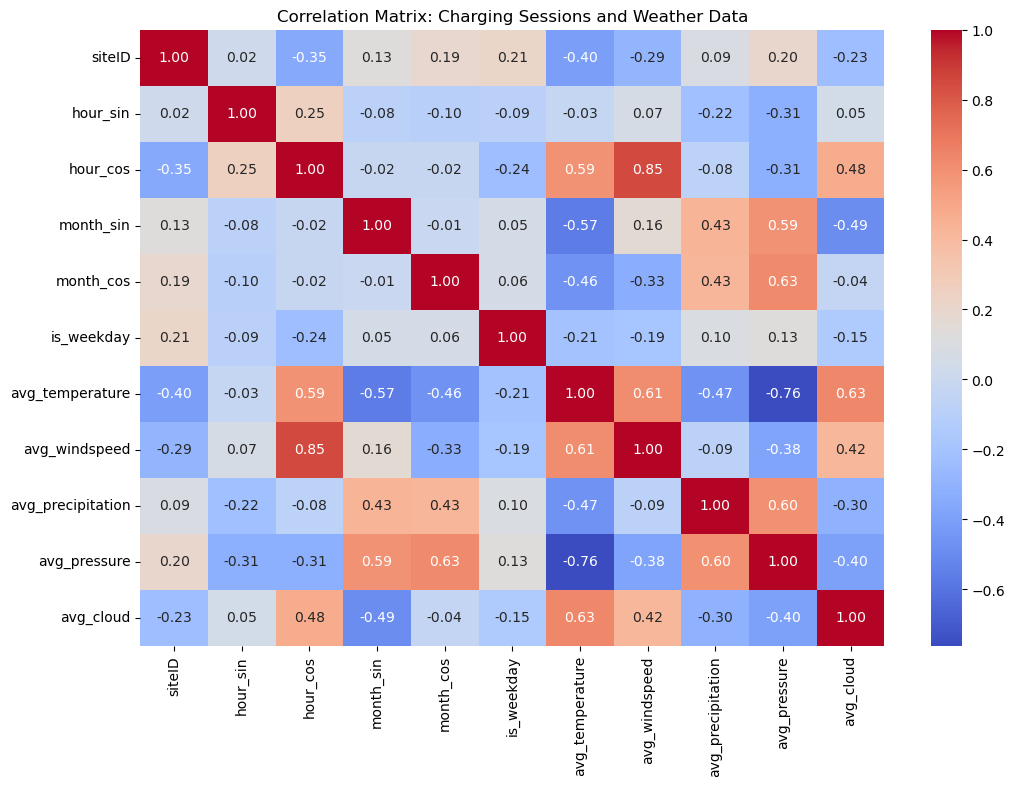

In [22]:
# choice of relecant numeric features 
correlation_features = [
    'siteID', 'hour_sin', 'hour_cos', 
    'month_sin', 'month_cos', 'is_weekday',
    'avg_temperature', 'avg_windspeed',  'avg_precipitation', 'avg_pressure', 'avg_cloud'
]

# calculate the correlation 
correlation_matrix = merged_sessions[correlation_features].corr()

# plot a heatmap of the correlation 
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix: Charging Sessions and Weather Data')
plt.show()
### 2. Find Optimal Machine Learning Method

### 2. Find Optimal Machine Learning Method

#### 2.1. Polynomial Regression

#### Neural network

### 2. Developing Predictive Models

#### 2.1. Train Models

#### 2.3. Lasso Regression

#### 2.4. Ridge Regression

In [23]:
# count the stations for each siteID 
stations_per_site = charging_sessions_data.groupby('siteID')['stationID'].nunique().reset_index()
stations_per_site.rename(columns={'stationID': 'total_stations'}, inplace=True)

print(stations_per_site)

   siteID  total_stations
0       0              54
1       1              52


In [24]:
# Calculate the duration of each session
charging_sessions_data['connectionTime'] = pd.to_datetime(charging_sessions_data['connectionTime'])
charging_sessions_data['disconnectTime'] = pd.to_datetime(charging_sessions_data['disconnectTime'])
charging_sessions_data['duration'] = (charging_sessions_data['disconnectTime'] - charging_sessions_data['connectionTime']).dt.total_seconds() / 3600  # Dauer in Stunden

# Summarise the loading times per hour and site
hourly_utilization = charging_sessions_data.groupby(['connectionTime', 'siteID']).agg(
    active_time=('duration', 'sum'),  # Summe der Ladezeit in Stunden
).reset_index()

# Add the total number of stations for each site
hourly_utilization = hourly_utilization.merge(stations_per_site, on='siteID', how='left')

# Calculate the utilization per hour
hourly_utilization['utilization'] = hourly_utilization['active_time'] / (hourly_utilization['total_stations'] * (hourly_utilization['connectionTime'].dt.hour + 1))

# Check the first five results
# print(hourly_utilization.head())

# prediciting utilization value

hourly_utilization.head()

,connectionTime,siteID,active_time,total_stations,utilization
0,2018-04-25 13:45:10+00:00,0,11.185000,54,0.014795
1,2018-04-25 13:45:50+00:00,0,9.315278,54,0.012322
2,2018-04-25 14:37:06+00:00,0,9.307778,54,0.011491
3,2018-04-25 14:40:34+00:00,0,8.377222,54,0.010342
4,2018-04-25 14:43:50+00:00,0,10.561111,54,0.013038


#### 2.5. Random Forest

In [ ]:
# merge datasets
merged_data = pd.merge(charging_sessions_data, weather_data) # pd.merge(charging_sessions_data, weather_data, on=['timestamp']

# Select Features and Target
# Define target variable
target = 'utilization'

# Define features (excluding the target and identifiers)
X = merged_data.drop(['utilization'], axis="columns") # features
y = merged_data['utilization'] # target variable

# split dataset into training and testing sets
# 30% test data and 70% training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# train model on 100 random trees
rf_model = RandomForestRegressor(n_estimators=100, bootstrap=True, random_state=42) # we select boostrapp, i.e. we use bagging
rf_model.fit(X_train,y_train)

ValueError: could not convert string to float: 'Wed, 15 May 2019 18:35:59 GMT'

In [ ]:
# predict on test set
y_pred = model.predict(X_test)

# evaluate performance based on metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred) # good performance = close to 1

NameError: name 'model' is not defined

In [ ]:
# hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300], # no of trees
    'max_depth': [10, 20, 30], # depth of each tree
    'min_samples_split': [2, 5, 10], # no required to split
    'min_samples_leaf': [1, 2, 4] # min samples required to node
}

rf_model_cv = GridSearchCV(estimaro=rfr, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', end_jobs = -1)
rf_model_cv.fit(X_train, y_train)

In [ ]:
# predict on test set
y_pred = model.predict(X_test)

# evaluate performance based on metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

#### 2.6. Neural Network

### 3. Developing Predictive Models

#### 3.1. Train Models

#### 3.2. Cross-Validation

#### 3.3. Performance Evaluation

### 4. Examples for Business Case

#### 4.1. Visualizing Prediction Data

#### 4.2. Example Prediction